## Bias Variance Decomposition

We start from the aspect of model complexity and fit that we have seen during the last lesson.
We take the following example from the book _Statistical Rethinking_ (Richard McElreath, Chapman and Hall/CRC, 2015). 

<hr>

Supposes:

- Y is random
- Model is random (because it can be trated as a random quantity based on the sampling of the training data)

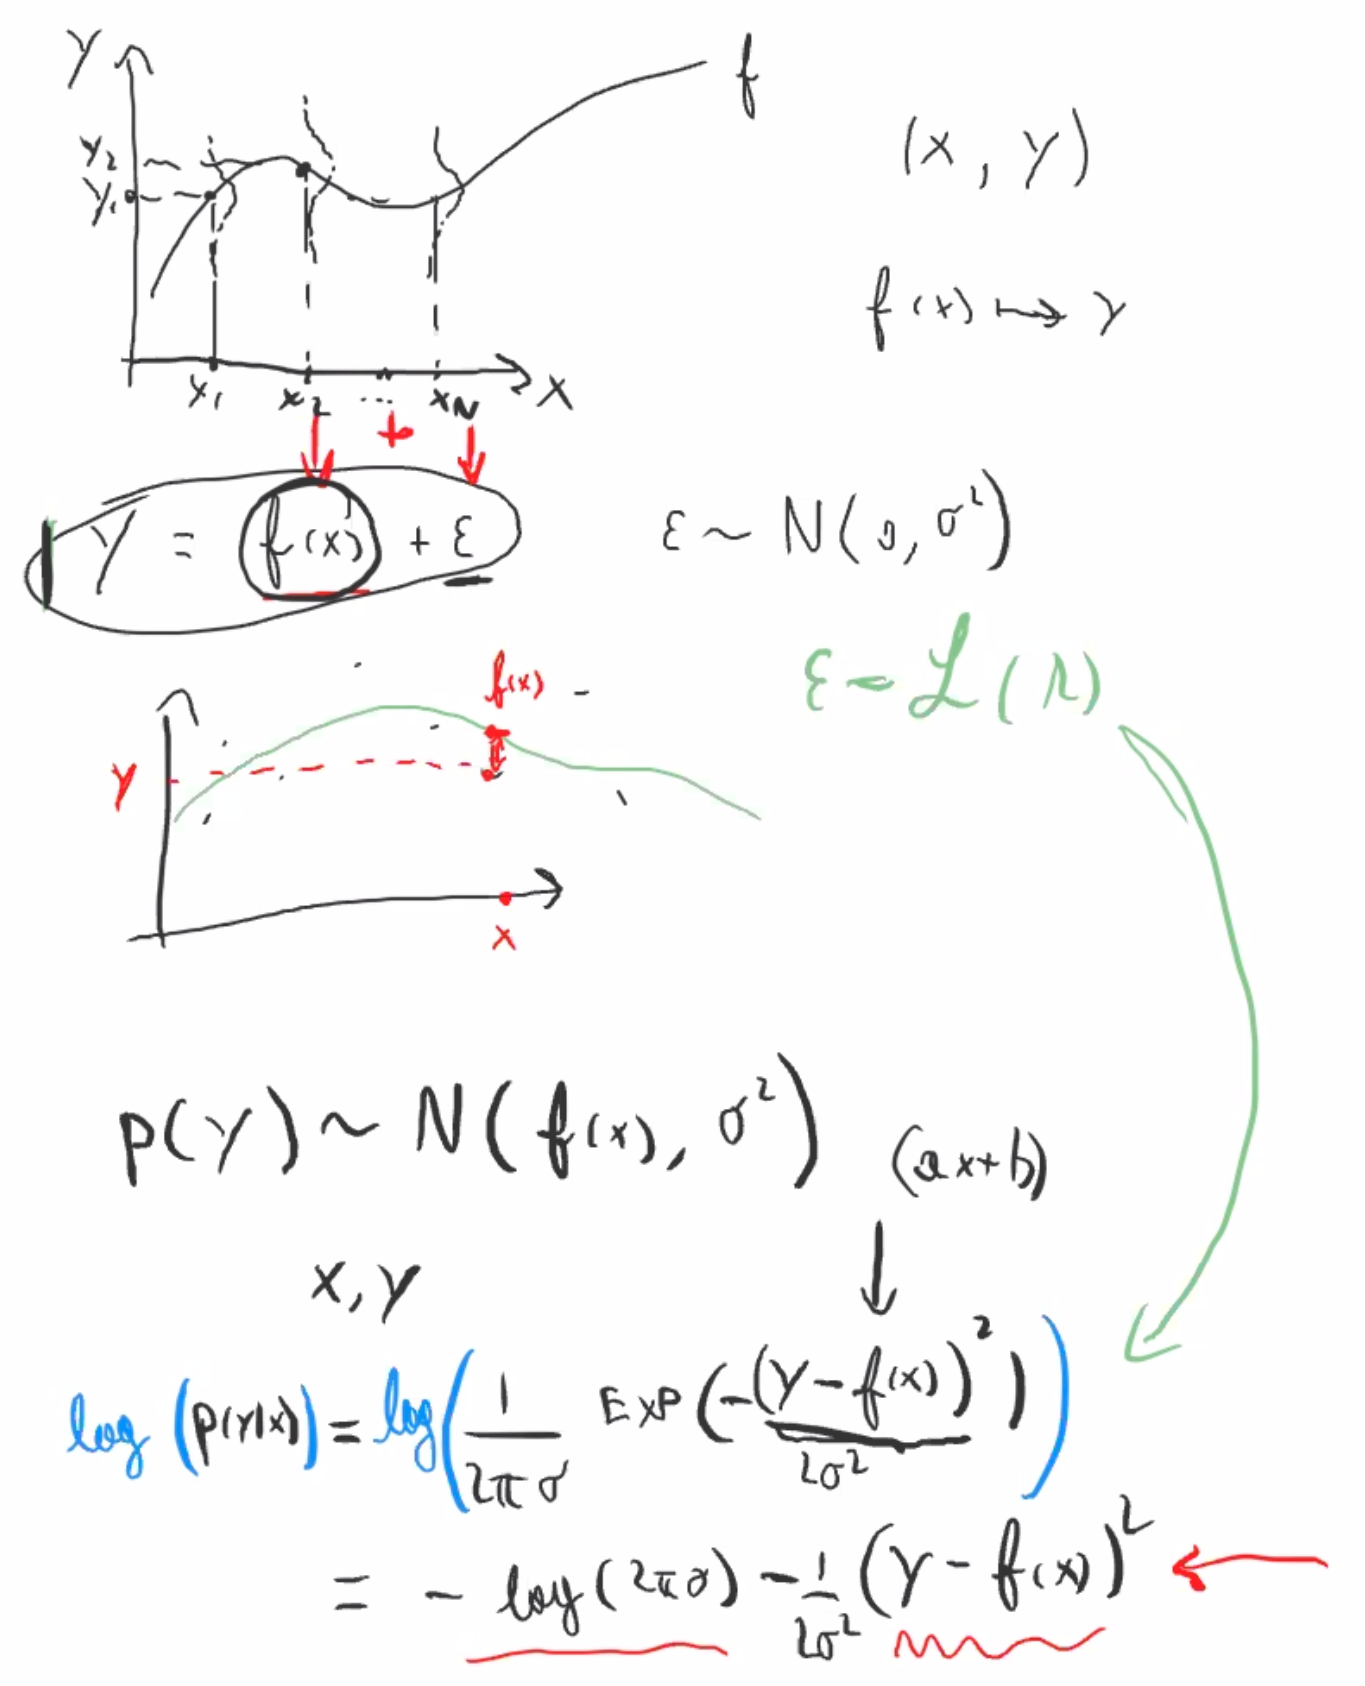

In [1]:
from IPython.display import Image
Image('prez.png', width=600)

<hr>

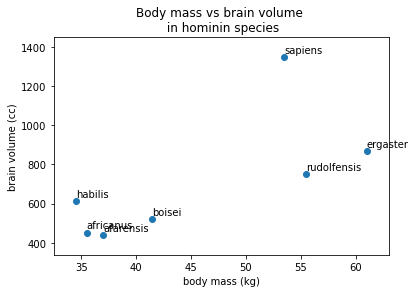

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

df = pd.DataFrame(data = {'species': ["afarensis","africanus","habilis","boisei", "rudolfensis","ergaster","sapiens"],
                          'brainvol_cc': [438 , 452 , 612, 521, 752, 871, 1350], 
                          'mass_kg': [37.0 , 35.5 , 34.5 , 41.5 , 55.5 , 61.0 , 53.5]})

plt.scatter(df.mass_kg,df.brainvol_cc)
plt.ylabel('brain volume (cc)')
plt.xlabel('body mass (kg)')
plt.ylim([min(df.brainvol_cc) - 100, max(df.brainvol_cc) + 100])
plt.xlim([min(df.mass_kg) - 2, max(df.mass_kg) + 2])
plt.title('Body mass vs brain volume \n in hominin species')
for i in range(len(df.mass_kg)):
    plt.annotate(df.species[i],(df.mass_kg[i], df.brainvol_cc[i] + 20))

#plt.show()

As done in the last lesson, we examine the behaviour of models with different complexity: polynomial functions with degree from $0$ to $6$.

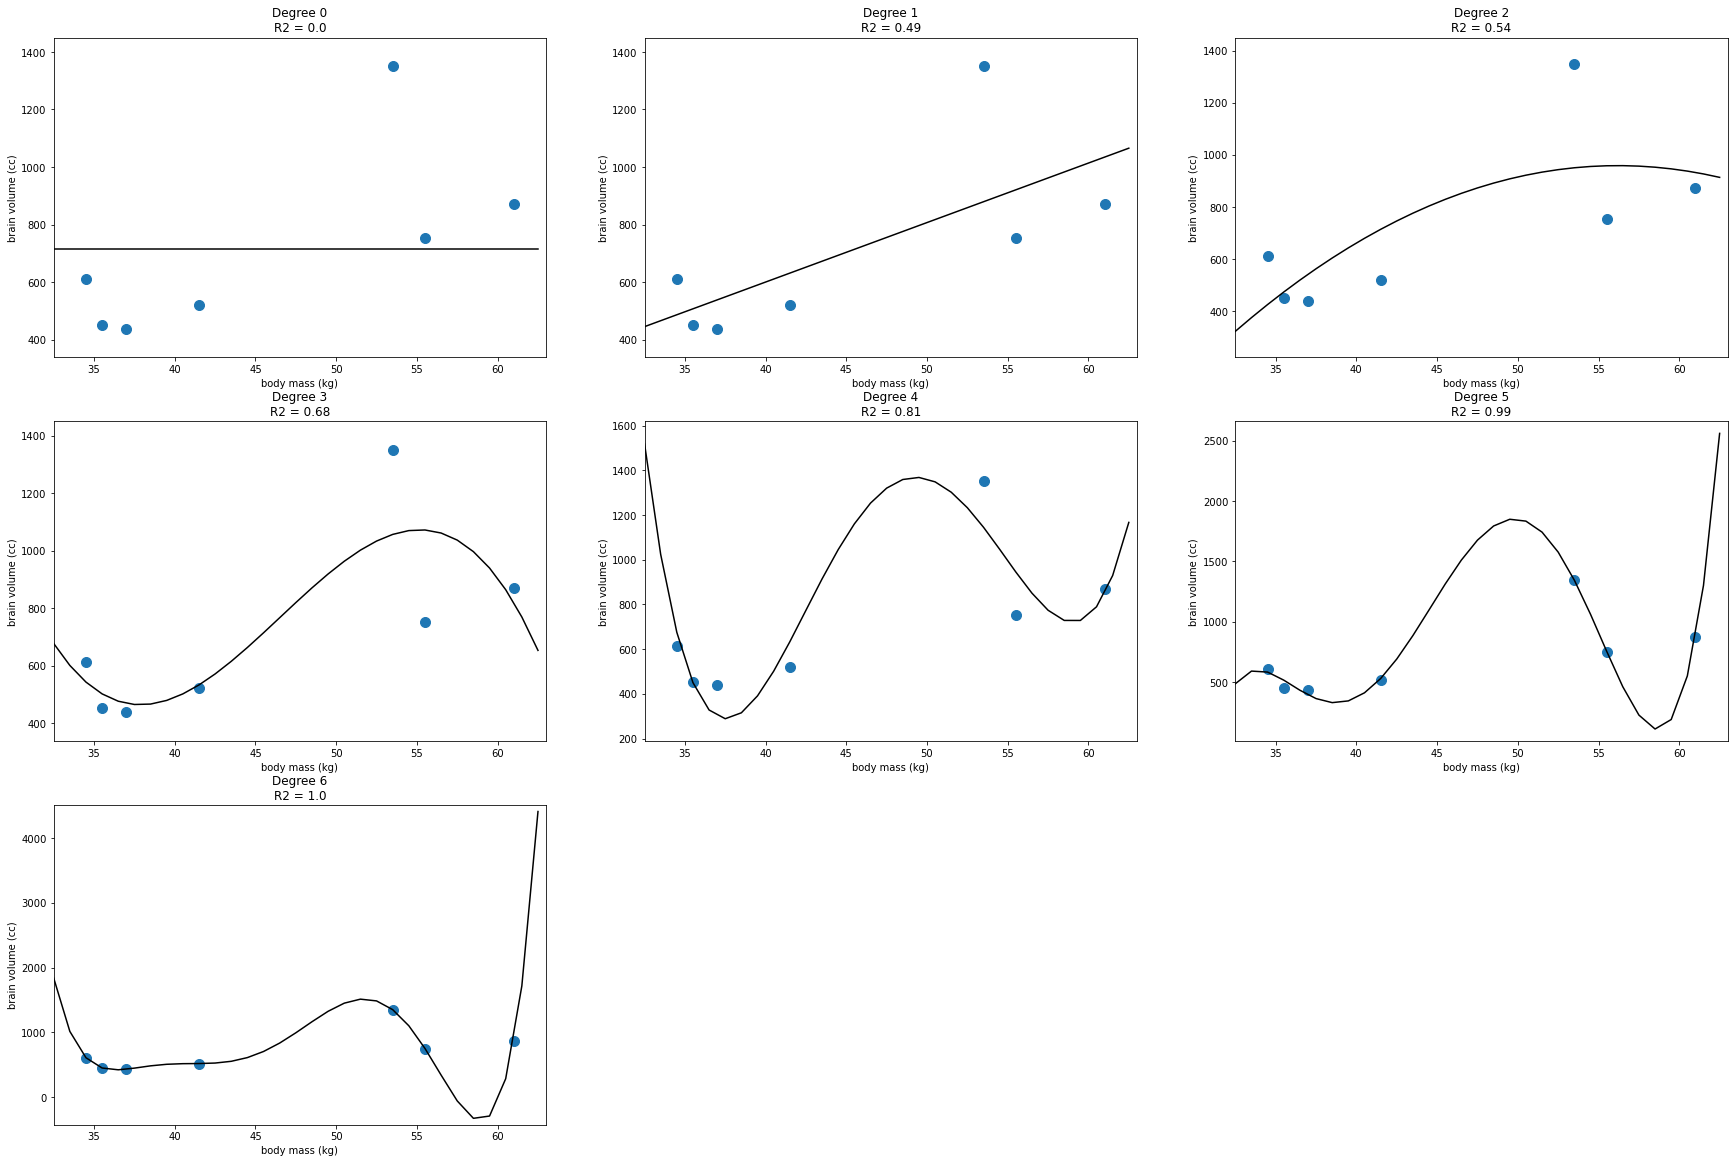

In [3]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

def R2(y_real,y_pred):
    y_avg = np.mean(y_real)
    SS_tot = np.sum((y_real - y_avg)**2)
    SS_expl = np.sum(( y_pred - y_avg)**2)
    SS_res = np.sum((y_real - y_pred)**2)
    return round(1 - SS_res/SS_tot,2)

plt.figure(figsize=(30,20))

for i in range(7):
    plt.subplot(3,3,i+1)
#    sns.regplot(x=df.mass_kg.values, y=df.brainvol_cc.values, order=i, n_boot = 2)
    poly = PolynomialFeatures(i)
    x_poly = poly.fit_transform(df.mass_kg.values.reshape(-1,1))
    reg_poly = linear_model.LinearRegression()
    reg_poly.fit(x_poly,df.brainvol_cc) 
    
    plt.scatter(df.mass_kg,df.brainvol_cc,s=100)
    
    prediction = reg_poly.predict(x_poly)
    R2_coeff = R2(df.brainvol_cc,prediction)
    
    predict_range = np.arange(min(df.mass_kg) - 2, max(df.mass_kg) + 2)
    poly_range = poly.fit_transform(predict_range.reshape(-1,1))
    plt.plot(predict_range,reg_poly.predict(poly_range),c='black')
    
    plt.ylabel('brain volume (cc)')
    plt.xlabel('body mass (kg)')
    max_y = max(np.hstack([reg_poly.predict(poly_range),df.brainvol_cc]))
    min_y = min(np.hstack([reg_poly.predict(poly_range),df.brainvol_cc]))
    plt.ylim([min_y - 100, max_y + 100])
    plt.xlim([min(df.mass_kg) - 2, max(df.mass_kg) + 2])
    plt.title('Degree ' + str(i) + '\nR2 = ' + str(R2_coeff))

plt.show()

We can see that for increasing complexity of the model, the prediction gets closer to the data at observed points. Note the increase of the $R^2$ up to the value of 1! The degree 6 polynomials actually fits all the data perfectly. Why this happens?

The reason is comes from a simple linear algebra consideration. We have 7 data points, i.e. couples $(x_i, y_i)$, while the 6-th order polynomial fit has 7 coefficients in total:

$$ f^6 (x) = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + a_4 x^4 + a_5 x^5 + a_6 x^6.$$

Estimating the coefficients of the regression problem is then equivalent at solving a linear system with 7 equations and 7 unknowns, which has one and only one unique possible solution. The problem is therefore over-constrained for the data at disposal: with a sufficient number of parameters we can fit all the data exactly. However, the behaviour of the models at the unseen points becomes increasingly unstable. This aspect is particularly evident in the extremities of the domain, and in the data gap in between the points $x=41.5$ and $x=55.5$. These over-parameterized models are actually _overfitting_ the data.

On the other hand, the constant model (0-degree polynomial) is clearly not providing a reasonable model of the relationship between body mass and brain volume. It is actually _underfitting_.

$\mathbf{Exercise.}$ Why the $R^2$ score is 0 in the case of the constant prediction?

Another interesting way of explaining this issue can be seen as a problem of a model stability with respect to the data:



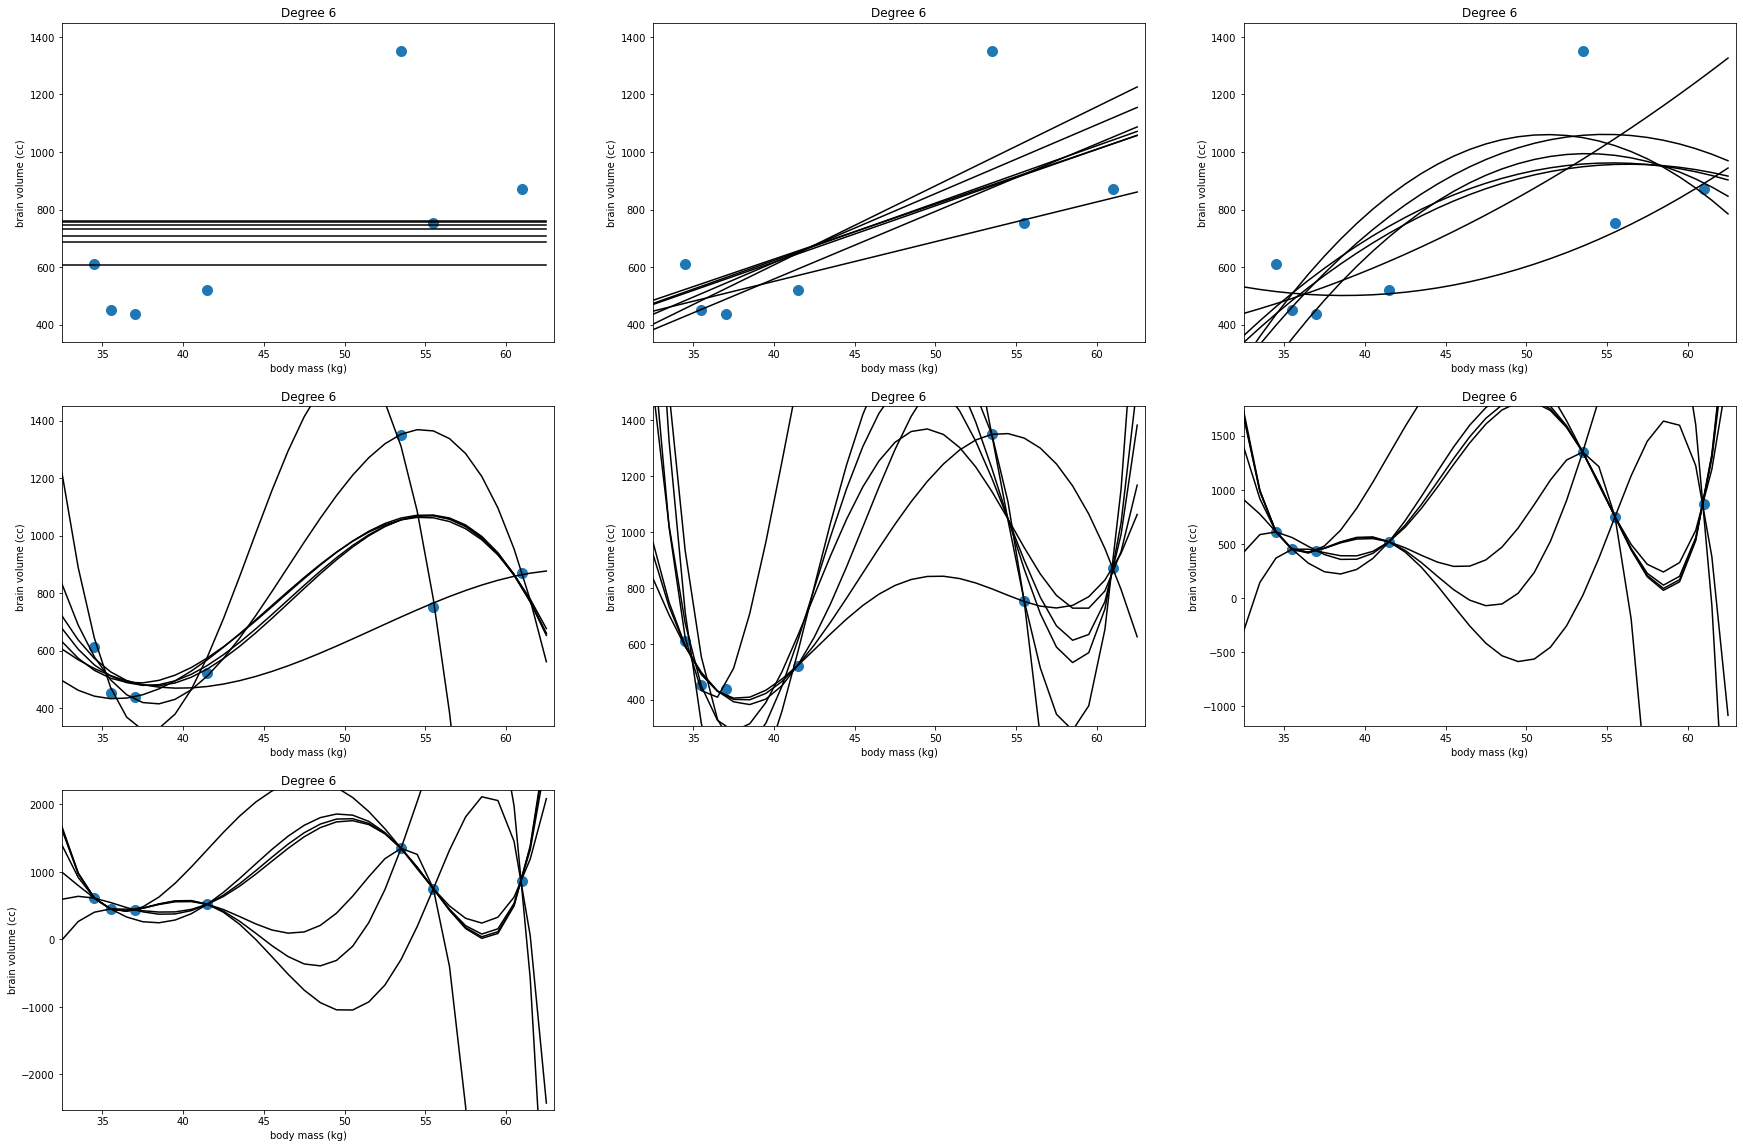

In [4]:
plt.figure(figsize=(30,20))

for i in range(7):
    plt.subplot(3,3,i+1)
    poly = PolynomialFeatures(i)
    plt.scatter(df.mass_kg,df.brainvol_cc,s=100)
    
    ## We iteratively remove only 1 data point from the dataset
    ## we fit the model on the remaining data and we plot the prediction
    for i in range(len(df.mass_kg.values)):
        x_poly = poly.fit_transform(np.delete(df.mass_kg.values,i).reshape(-1,1))
        reg_poly = linear_model.LinearRegression()
        reg_poly.fit(x_poly,np.delete(df.brainvol_cc.values,i)) 
    
        prediction = reg_poly.predict(x_poly)
    
        predict_range = np.arange(min(df.mass_kg) - 2, max(df.mass_kg) + 2)
        poly_range = poly.fit_transform(predict_range.reshape(-1,1))
        plt.plot(predict_range,reg_poly.predict(poly_range),c='black')
    
    plt.ylabel('brain volume (cc)')
    plt.xlabel('body mass (kg)')
    max_y = max(np.hstack([reg_poly.predict(poly_range),df.brainvol_cc]))
    min_y = min(np.hstack([reg_poly.predict(poly_range),df.brainvol_cc]))
    plt.ylim([min_y - 100, max_y + 100])
    plt.xlim([min(df.mass_kg) - 2, max(df.mass_kg) + 2])
    plt.title('Degree ' + str(i) )

plt.show()

We see that the stability of the models with respect to the variation in the data decreases with the model complexity. Overfitting implies high sensitivity to the training data sample, while underfitting implies low sensitivity to the data in general.

This aspect is formalized in statistics as the __bias-variance trade-off__. To illustrate this concept we follow a derivation adapted from the book _Pattern Recognition and Machine Learning_ (C.M. Bishop, Springer, 2006). 


Within a generative model setting, we can assume that an observed target value $y_i$ given the data  $x_i$ is a noisy realization of an underlying function $f$. In a general form: $y = y(x) = f(x) + \epsilon,$ with $\epsilon \sim \mathcal{N}(0,\sigma^2)$. The distribution of $y$ at a point $x$ has the following parameters: 

$$\mathbf{E}_y[y|x] = f(x)$$
$$\mathbf{Var}_y(y|x) =  \sigma^2$$

Let's also denote with $\hat{y_i}$ the model predictions. Note that the model predictions are independent from $y$. The loss of our prediction is obtained by integrating the mean squared difference between target and predictions, across all possible data $x$ and realization of target variables $y$:

\begin{align*}
\textbf{Loss}  &= \mathbf{E}_{x,y}[(y - \hat{y\,})^2] = \\ 
             &= \mathbf{E}_{x,y}[(y - f(x) + f(x) -\hat{y\,})^2] =\\
             &= \mathbf{E}_{x,y}[ (y - f(x))^2] + \mathbf{E}_{x,y}[(f(x) -\hat{y\,})^2] + 2 \mathbf{E}_{x,y}[(y - f(x))(f(x) -\hat{y\,})]
\end{align*}

We first observe that the cross-term vanishes. We first note that:


\begin{align*}
        \mathbf{E}_{x,y}[(y - f(x))(f(x) -\hat{y\,})] & = \mathbf{E}_{x}[\mathbf{E}_{y}[(y - f(x))(f(x) -\hat{y\,}) \,|\, x]].
\end{align*}


By developing the internal expectation with respect to $y$:
\begin{align*}
        \mathbf{E}_{y}[(y - f(x))(f(x) -\hat{y\,}) \,|\, x] & = (f(x) -\hat{y\,}) \mathbf{E}_{y}[(y - f(x)) \,|\, x] \\
                & = (f(x) -\hat{y\,}) (\mathbf{E}_{y}[(y\,)\,|\, x] - f(x))  \\
                & = (f(x) -\hat{y\,}) (f(x) - f(x)) = 0
%        f(x)\mathbf{E}_{y}[{y}]  - \mathbf{E}_{y}[y\hat{y\,}] - \mathbf{E}_{y}[f(x)^2] + f(x) \mathbf{E}[\hat{y\,}]\\
%        & = - \mathbf{E}_{y}[y\hat{y\,}] + f(x) \mathbf{E}_{y}[\hat{y\,}] \\
%        & = - \mathbf{E}_{y}[(f(x) + \epsilon)\hat{y\,}] + f(x) \mathbf{E}_{y}[\hat{y\,}] \\
%        & = - f(x)\mathbf{E}_{y}[\hat{y\,}] - \mathbf{E}_{y}[\epsilon\hat{y\,}] + f(x) \mathbf{E}_{y}[\hat{y\,}] \\
%        & = - \mathbf{E}_{y}[\epsilon] \mathbf{E}_{y}[\hat{y\,}]  = 0.
\end{align*}





Back to formula the loss formula, we identify the following relationship:

\begin{align*}
\textbf{Loss}  & =  \mathbf{E}_{x,y}[(y - f(x))^2] + \mathbf{E}_x[(f(x) -\hat{y\,})^2] \\
               & =  \mathbf{E}_{x}[\mathbf{E}_{y}[(y - f(x))^2 \, |\, x]] + \mathbf{E}_x[(f(x) -\hat{y\,})^2] \\
               & = \mathbf{E}_{x}[Var(y | x)] + \mathbf{E}_x[(f(x) -\hat{y\,})^2] 
\end{align*}


We note therefore that the optimal model solution, the one associated with minimal loss, is given by the expectation of the second term. The first term is the variance of the data, averaged across the observations. It represents the variability of the target and quantifies the intrinsic data noise. Note that it is independent of the model predictions $\hat{y}$.

We note now that the prediction $\hat{y}$ depends on the the training dataset: $\hat{y\,} = \hat{y\,}(\mathcal{D})$. Depending on the the training set of available data points $\mathcal{D} =\{(x_i , y_i)\}$, the model solution will vary according to the minimization of the Loss term $\mathbf{E}_{x}[(f(x) -\hat{y\,})^2]$. We consider the expectation of the model prediction across data-points, $\mathbf{E}_{\mathcal{D}}[\hat{y\,}|\mathcal{D}]$, and we write:

\begin{align*}
    (f(x) -\hat{y\,})^2 & = (f(x) - \mathbf{E}_{\mathcal{D}}[\hat{y\,}] + \mathbf{E}_{\mathcal{D}}[\hat{y\,}] -\hat{y\,})^2 \\
        & = (f(x) - \mathbf{E}_{\mathcal{D}}[\hat{y\,}])^2 + (\mathbf{E}_{\mathcal{D}}[\hat{y\,}] -\hat{y\,})^2 + 2 (f(x) - \mathbf{E}_{\mathcal{D}}[\hat{y\,}]) ((\mathbf{E}_{\mathcal{D}}[\hat{y\,}] -\hat{y\,})
\end{align*}

Taking again the expectation of the equality with respect to the data $\mathcal{D}$, we observe that the cross-term vanishes:

\begin{align*}
    \mathbf{E}_{\mathcal{D}}[ (f(x) - \mathbf{E}_{\mathcal{D}}[\hat{y\,}]) (\mathbf{E}_{\mathcal{D}}[\hat{y\,}] -\hat{y\,}) ] & =  
    f(x) \mathbf{E}_{\mathcal{D}}[\hat{y\,}] - f(x) \mathbf{E}_{\mathcal{D}}[\hat{y\,}] - \mathbf{E}_{\mathcal{D}}[\hat{y\,}]^2 + \mathbf{E}_{\mathcal{D}}[\hat{y\,}]^2
\end{align*}

We finally obtain: 

$$\mathbf{E}_{\mathcal{D}}(f(x) -\hat{y\,})^2  = (f(x) - \mathbf{E}_\mathcal{D}[\hat{y\,}])^2 + \mathbf{E}_\mathcal{D}[  (\mathbf{E}_\mathcal{D}[\hat{y\,}] -\hat{y\,})^2 ].$$

This last equality is of great importance, as it tells us that the expected squared difference between the target function and the predictions depends on two terms

- __Bias__ : the difference between the averaged predictions over all the posible datasets and the target function (first term). 
- __Variance__: the variance of the predictions over the possible datasets (second term). It measures the variability of the predictions respect to the change in the data.


Back to our Loss function, we finally get:

$$\textbf{Loss}  =  \mathbf{Noise} + \mathbf{Bias}^2 + \mathbf{Variance},$$

where,

\begin{align*}
\mathbf{Noise}    &=  \int_x Var(y | x) \, p(x)dx\\
\mathbf{Bias}^2   &= \int_x (f(x) - \mathbf{E}_\mathcal{D}[\hat{y\,}])^2 \, p(x)dx\\
\mathbf{Variance} &=  \int_x \mathbf{E}_\mathcal{D}[(\mathbf{E}_\mathcal{D}[\hat{y\,}] -\hat{y\,})^2] \, p(x)dx
\end{align*}


To practically compute (and perhaps understand) the bias-variance tradeoff we need of: 

- a ground truth function f(x),
- a noise model for the observations,
- a set of (potentially infinite) available data for fitting our model.

When these ingredients are available, we need to:
- compute the average of the model predictions across datasets
- compute the dispersion of the model average with respect to the ground truth function f(x)
- compute the variance of the model predictions across datasets
- integrate bias and variance across all the data points

$\mathbf{Exercise}$. Implement the above steps to compute bias and variance for the polynomial regression for degrees $d=0, 1, \ldots, 15$, when $f(x) = sin(x)$.


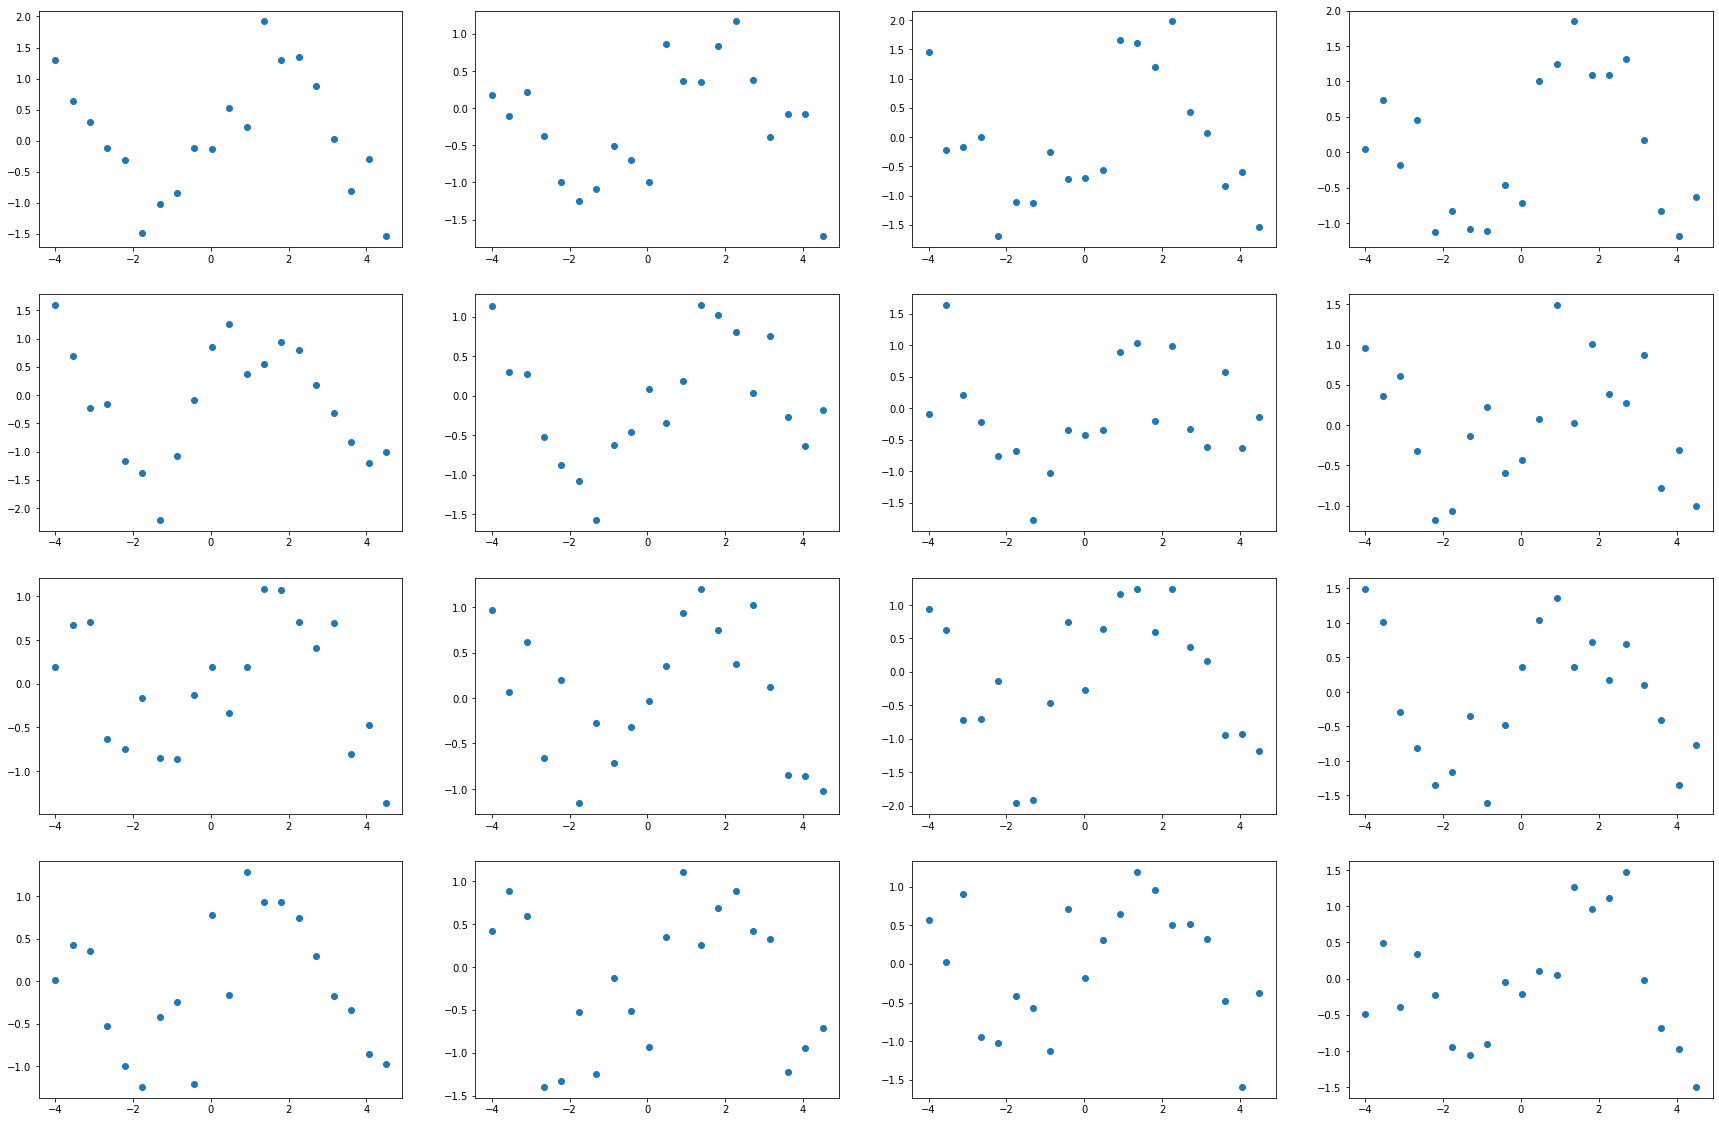

In [13]:
x_min = -4
x_max = 4.5
N_samples = 20

def f(x):
    return(np.sin(1*x))

def sample_data_batch(x_min,x_max, N_samples):
    ## The x-data is fixed (no variability here)
    X = np.linspace(x_min,x_max,N_samples)
    noise_level = 0.5
    noise = noise_level * np.random.randn(N_samples)
    ## The variability here depends only from the noise we add on the samples
    return [X,f(X) + noise]


X = np.linspace(x_min,x_max,N_samples)


all_bias = []
all_var = []
all_bias_variance = []

plt.figure(figsize=(30,20))

## For every plynomial degree
for degree in range(16):
    plt.subplot(4,4,degree+1)
    ## Plotting a sample data batch
    plt.scatter(X,sample_data_batch(x_min,x_max, N_samples)[1])
    
    poly = PolynomialFeatures(degree)
    prediction_on_data_sample = []
    ## Here we generate a sample distribution for our predictions based on different training data samples
    for i in range(50):
        ## Sampling a new data batch
        current_data = sample_data_batch(x_min,x_max, N_samples)
        x = current_data[0]
        y = current_data[1]
        ## Model traning        
        x_poly = poly.fit_transform(x.reshape(-1,1))
        reg_poly = linear_model.LinearRegression()
        reg_poly.fit(x_poly, y)
        
        ## saving the prediction (and eventually plotting the results)
        prediction_on_data_sample.append(reg_poly.predict(x_poly))
        
    ## We compute E_D(y_hat) (and eventually plot the result)
    avg_pred = np.mean(prediction_on_data_sample, 0)
    fx = f(x)
    bias = np.sum((avg_pred-fx)**2)

    variance = np.sum(np.var(prediction_on_data_sample,0))
    
    all_bias.append(bias)
    all_var.append(variance)
    
    all_bias_variance.append(bias+variance)
    
    ## We compute Var_D(y_hat)
    ## We first compute several samples for (y_hat - E(y_hat))**2
        ## Sampling a new data batch
        # complete...
        ## Model traning        
        # complete...
        ## Compute the variance term as (prediction - E_D(y_hat))
        # complete...

    ## We compute the variance E[(y_hat - E(y_hat))**2]
    # complete...
    

    ## We integrate bias and variance along the x-axis
    # compute bias as mean_x( (f(X) -  expect_pred)**2)
    # complete...
    # compute variance as mean_x( variance)
    # complete...

    #update tot_bias and tot_var with computed values for current polynomial degree


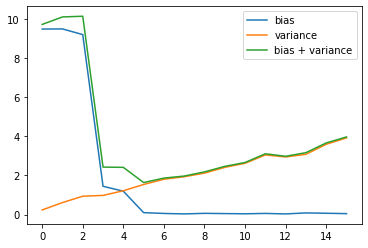

In [17]:
plt.plot(range(16),all_bias, label = 'bias')
plt.plot(range(16),all_var, label = 'variance')
plt.plot(range(16),all_bias_variance, label = 'bias + variance')
plt.legend()
plt.show()

- Warning 1: This quantification entirely depends on the ability to obtain an infinite number of samples.
- Warning 2: The bias-variance decomposition is defined with respect to the quadratic error loss
- Warning 3: Unfortunately, in real life, the function $f(x)$ is not known...

## Bias-variance tradeoff and training-testing error

The bias-variance trade-off is closely related to the aspect of training-testing error:


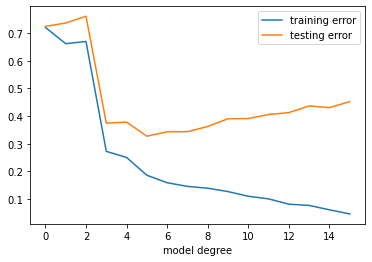

In [18]:
train_error = []
test_error = []

## Training and testing error for increasing polynomial degree
for degree in range(16):

    ## We define our polynomial model of given degree
    poly = PolynomialFeatures(degree)
    prediction_on_data_sample = []
    
    train_error_d = []
    test_error_d = []
    
    ## We compute the testing error for several (200) testing data
    for i in range(200):
        ## Generating a sample training dataset
        current_data = sample_data_batch(x_min,x_max, N_samples)
        ## Model training
        x_poly = poly.fit_transform(current_data[0].reshape(-1,1))
        reg_poly = linear_model.LinearRegression()
        reg_poly.fit(x_poly, current_data[1])
        
        ## Generating a testing dataset
        testing_data = sample_data_batch(x_min,x_max, N_samples)
        x_test_poly = poly.fit_transform(testing_data[0].reshape(-1,1))
        
        ## Computing the predictions on both training and testing data
        prediction_on_data_test = (reg_poly.predict(x_test_poly))
        prediction_on_data_train = (reg_poly.predict(x_poly))
        
        ## Storing the prediction errors for both training and testing data        
        train_error_d.append(np.mean((current_data[1] - prediction_on_data_train)**2))
        test_error_d.append(np.mean((testing_data[1] - prediction_on_data_test)**2))

    train_error.append(np.mean(train_error_d))
    test_error.append(np.mean(test_error_d))
    
plt.plot(range(16),train_error, label = 'training error')
plt.plot(range(16),test_error, label = 'testing error')
plt.xlabel('model degree')
plt.legend()
plt.show()

The relationship between training and testing error has been widely studied in the literature. In the book _The Elements of Statistical Learning_ (Hastie, Tibshirani and Friedman, Stanford University) this relationship is rigorously formalized.

Given a training set $\mathcal{T} = \{(x_1,y_1), \ldots, (x_N,y_N)\}$, and predictions $\hat{y_i} = \hat{f\,}(x_i)$ denote the training error as:

$$\overline{\mbox{err}} = \frac{1}{N}\sum \mathbf{Loss}(y_i,\hat{y_i})$$

In reality, what we would like to assess is the _generalization error_. This error is defined by  evaluating the model at any test point $(X^0,Y^0)$

$$ \mbox{Err}_\mathcal{T} = \mathbf{E}_{X^0,Y^0}[ \mathbf{Loss}(Y^0,\hat{f\,}(X_0) ) ], $$

and by averaging across all the possible training sets:


$$ \mbox{Err} = \mathbf{E}_\mathcal{T}[\mbox{Err}_\mathcal{T}]. $$


A fitting method typically adapts to the training data, and hence the apparent or training error $\overline{\mbox{err}}$ will be an overly optimistic estimate of the generalization error. 

Let's consider new response values samples at each of the training point, and call them $Y^0 = \{ (x_1,Y_1^0), \ldots, (x_N,Y_N^0)  \}$. We define the _in-sample error_ as:

$$ Err_{in} = \frac{1}{N}\sum_i \mathbf{E}_{Y^0}[\mathbf{Loss}(Y_i^0, \hat{y_i}) | \mathcal{T}] $$

This error quantifies the error on samples not used for training the model, but defined on the same training input $x_1, \ldots, x_N$. This error thus depends only on the variability of the samples.

We define the _model optimism_ as the difference:

$$ \mbox{op} = Err_{in} - \overline{\mbox{err}} $$

We would like to average this quantity over all the possible training set, therefore by considering:

$$ \omega = \mathbf{E}_y[\mbox{op}] .$$

It can be demonstrated that for a squared loss function, the average optimism $\omega$ is:

$$ \omega = \frac{2}{N}\sum_1^N Cov(\hat{y_i}, y_i)   $$

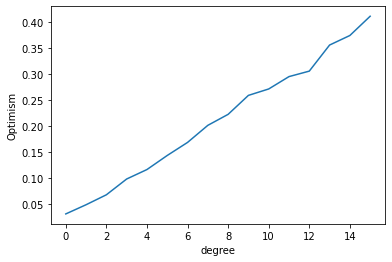

In [19]:
def f(x):
    return(np.sin(1*x))

def sample_data_batch(x_min,x_max, N_samples):
    ## As before, the x-data is always the same
    X = np.linspace(x_min,x_max,N_samples)
    noise_level = 0.5
    noise = noise_level * np.random.randn(N_samples)
    ## The only variability is in the noise around the function f(x)
    return [X,f(X) + noise]


cov_terms = []

## We compute the optimism for every polynomial model
for degree in range(16):
    ## We define our polynomial model of given degree    
    poly = PolynomialFeatures(degree)
    y = []
    y_hat = []

    ## Here we want to compute the variability of the predictions y_hat according to the training data y
    ## Therefore, we create several scenarios (100) in which we store 
    ## some sample training data y and the associated predictions.
    ## These values will be used to compute the covariance Cov(y, y_hat)
    for i in range(100):
        ## We generate some training data
        train_data = sample_data_batch(x_min,x_max, N_samples)
        ## Storing the generated training data y
        y.append(train_data[1])
        ## Training the model
        x_poly = poly.fit_transform(train_data[0].reshape(-1,1))
        reg_poly = linear_model.LinearRegression()
        reg_poly.fit(x_poly, train_data[1])
        ## Storing the prediction y_hat associated to the training data y
        y_hat.append(reg_poly.predict(x_poly))

    ## The lists for y and y_hat have both dimensions (100,20), i.e. 100 computed values for each of the 20 sample points. 
    ## We can therefore compute the covariance that will have dimension (20, 20)
    ## Be Careful since the command np.cov(y.T,y_hat.T) returns a covariance of size (40,40) 
    ## corresponding to the matrix:
    ##
    ## |Cov(y,y)     Cov(y,y_hat)     |
    ## |Cov(y_hat,y) Cov(y_hat,y_hat) |
    ##
    ## Therefore we are interested only in the upper right (or lower left) part of the covariance
    cov = np.cov(np.array(y).T,np.array(y_hat).T)[:N_samples,N_samples:]
    ## We can finally compute the optimism
    cov_terms.append(2/N_samples * np.sum(cov.diagonal()))
    

plt.plot(range(16), cov_terms)
plt.xlabel('degree')
plt.ylabel('Optimism')
plt.show()

In the real world, we can sample from the available data under the assumption that the data sample faithfully represents our ideal data distribution. This idea is at the basis of two key operation in model selection: __cross-validation__ and __bootstrapping__.

## Bias-Variance trade-off in linear models

When the data has a linear relationship, $y_i = \mathbf{x}_i \mathbf{v} + \epsilon$, we can write the bias-variance decomposition explicitly.

In a least squares regression setting, the problem 

$$ LS = \|y -  X \mathbf{w}\|^2 $$

has solution $\mathbf{w} = X^+ y$, where $X^+$ is the pseudo-inverse of $X^+ = (X^TX)^{-1}X^T$.
Substituting the linear relationship for $y$ we obtain:

$$ \mathbf{w} = X^+ y = X^+ (X \mathbf{v} + \epsilon) = \mathbf{v} + X^+ \epsilon.$$

In particular we observe that the least squares estimate differs from the ground truth for the noise term $X^+ \epsilon$. This noise does not depend on the model, while depends uniquely from the data and noise. This is the $\mathbf{Noise}$ term of our decomposition.

To compute the $\mathbf{Bias}$, we need to compute $f(z) -\mathbf{E}_\mathcal{D}[\hat{y\,}]$ for a general point $z$:

\begin{align*}
f(z) -\mathbf{E}_\mathcal{D}[\hat{y\,}] &= z\mathbf{v} - \mathbf{E}_\mathcal{D}[z\mathbf{w}] \\
                                        &= z\mathbf{E}_\mathcal{D}(\mathbf{v} - \mathbf{w})\\
                                        &= -zX^+\mathbf{E}_\mathcal{D}[ \epsilon  ] = 0
\end{align*}

In a linear setting, the $\mathbf{Bias}$ is always 0. This is the consequence of using the squared error function, and of fitting a linear model to data with a linear relationship.
The $\mathbf{Variance}$ is computed as follows:

\begin{align*}
\mathbf{E}_\mathcal{D}[(\mathbf{E}_\mathcal{D}[\hat{y\,}] -\hat{y\,})^2] &= \mathbf{E}_\mathcal{D}[(\mathbf{E}_\mathcal{D}[z (\mathbf{v} + X^+ \epsilon)] - z (\mathbf{v} + X^+ \epsilon))^2) \\
        &= Var(z  X^+ \epsilon) = (z  X^+) Var(\epsilon)(z  X^+)^T,
\end{align*}

since we assume as usual Gaussian distrbuted noise $\epsilon\sim\mathcal{N}(0,\sigma^2)$. Therefore, we obtain:

\begin{align*}
\mathbf{E}_\mathcal{D}[(\mathbf{E}_\mathcal{D}[\hat{y\,}] -\hat{y\,})^2] = \sigma^2 (z  X^+)^T(z  X^+) =\\
        & = \sigma^2 z (X^TX)^{-1}X^T X (X^TX)^{-1} z^T \\
        & = \sigma^2 z\,(X^TX)^{-1}z^T
\end{align*}

Therefore, the variance of the linear model is inversely proportional to the data matrix product $(X^TX)$. 
In particular, when the data $x$ is assumed to be Gaussian, $x\sim\mathcal{N}(0,Id)$, the variance can be approximated as: 

\begin{align*}
\mathbf{Var} & = \int_{z} \sigma^2 z\,(X^TX)^{-1}z^T \, p(z) dz \approx \frac{\sigma^2 d}{N},
\end{align*}

where $d$ is the dimension of the data, and $N$ is the number of samples. This last result shows that the variance is directly proportional to the data noise and dimensions, and inversely proportional to the number of samples.